In [1]:
import matplotlib.colors as mcolors
from collections import defaultdict
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logomaker
import itertools
import pybedtools
import json

In [2]:
import matplotlib
from pathlib import Path
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/"
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

In [4]:
sys.path.append(f"{PROJECT_DIR_s}2_train_models/")
from file_configs import MergedFilesConfig
sys.path.append(f"{PROJECT_DIR_s}6_call_motifs/")
import call_motifs_script

# Proportion of TREs with motifs

In [5]:
s = "HCT116"
model_type = "strand_merged_umap"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
merged_config = MergedFilesConfig(s, model_type, f"{PROJECT_DIR_o}procapnet/")
modisco_path = merged_config.modisco_counts_results_path
peak_path = merged_config.all_peak_path

In [6]:
coords = []
df = pd.read_table(peak_path, header=None)
for index, row in df.iterrows():
	coords.append(tuple(row[:3]))

In [7]:
# mapping between divergent and bidirectional elements

b1 = pybedtools.BedTool(f"{PROJECT_DIR_d}Peaks/PINTS/brm_CTCF_U1_and_CTCF_U2_erm_1_divergent_peaks.bed")
b2 = pybedtools.BedTool(f"{PROJECT_DIR_d}Peaks/PINTS/brm_CTCF_U1_and_CTCF_U2_erm_1_bidirectional_peaks.bed")
di2bi = defaultdict(set)
overlaps = b1.intersect(b2, wao=True)
for i in overlaps:
	if int(i.fields[-1]) > 0:
		chrom, start1, end1 = i.fields[:3]
		start2, end2 = i.fields[7:9]
		di2bi[(chrom, int(start1), int(end1))] = (chrom, int(start2), int(end2))

In [8]:
mapping = {}
for p, d in itertools.product(ps, ds):
	inputfile = f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed"
	df = pd.read_table(inputfile, header=None)
	for index, row in df.iterrows():
		e = (row[0], row[3], row[4])
		if e in di2bi:
			ind = coords.index(di2bi[e])
		else:
			ind = coords.index(e)
		mapping[ind] = (row[0], row[5], row[6], row[7], p, d)

In [9]:
outputfile = f"{PROJECT_DIR_o}procapnet/motifs_out/{s}/{model_type}/merged/mapping.json"
with open(outputfile, "w") as f:
	json.dump(mapping, f)

In [10]:
motif_names = ["SP", "ETS", "AP1", "NFY", 
			   "NRF1", "CREB", "ZBTB33", 
			   "TATA", "CTCF", "YY1", "ZNF143"
                ]
patterns_IDs = [0,1,2,3,
				5,4,11,
				22,8,6,9
				]

In [11]:
# chrom, hit_start + 2, hit_end - 2, motif_name, hit_peak_index, strand, motif_i

counts_hits_path = f"{PROJECT_DIR_o}procapnet/motifs_out/{s}/{model_type}/merged/counts_hits.bed"
df_motifs = pd.read_table(counts_hits_path, header=None)
df_motifs.head(2)

0       1       2     3  4  5   6
0  chr1  605487  605497  NRF1  1  +   5
1  chr1  629619  629625  TATA  2  -  10

In [12]:
# motif - peak id

motifs = defaultdict(set)
for index, row in df_motifs.iterrows():
	motifs[row[3]].add(row[4])

In [13]:
# Showing the proportion of motifs identified in divergent and unidirectional elements

results = []
for p in ps:
	es = set([e for e in mapping if mapping[e][-2]==p])
	results.append([len(motifs[motif] & es)/len(es)*100 for motif in motif_names])
df_perc = pd.DataFrame(results, index=ps, columns=motif_names)

In [14]:
max(df_perc.max()), min(df_perc.min())

(34.562465602641716, 0.27517886626307103)

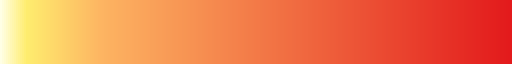

In [15]:
colors = [(0.0, "#ffffe5"), (0.05, "#ffed6f"), (0.2, "#fdb462"), (1, "#e31a1c")] 
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
cmap

In [16]:
def motif_perc(df, outputfile):
	fig, ax = plt.subplots(1, 2, figsize=(10, 2), gridspec_kw={'width_ratios': [30,1]})
	g = sns.heatmap(data=df, cmap=cmap, ax=ax[0], cbar=True, cbar_ax=ax[1])	
	g.set_xticklabels(g.get_xticklabels(), rotation=30, fontsize=bfontsize, fontweight="bold", ha="right")
	g.set_yticklabels([f"{p.capitalize()}\n(n={len([e for e in mapping if mapping[e][-2]==p])})" for p in ps], rotation=0, 
					  fontsize=bfontsize, fontweight="bold", ha="center")
	g.yaxis.set_tick_params(pad=50)
	
	ax[1].set_ylabel("TREs (%)", fontsize=bfontsize, fontweight="bold", labelpad=10)
	ax[1].tick_params(axis="y", labelsize=sfontsize)
	
	fig.subplots_adjust(wspace=0.1)
	plt.savefig(outputfile, bbox_inches="tight", dpi=300) 

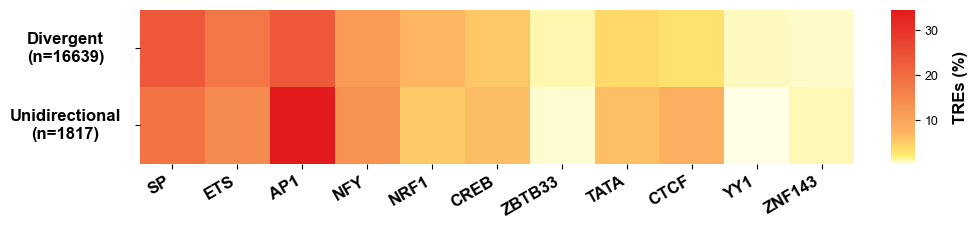

In [17]:
outputfile = f"{PROJECT_DIR_o}supp_figures/suppFig12a.pdf"
motif_perc(df_perc, outputfile)

# Motif distribution

In [18]:
revs = {}
for motif in motif_names:
	revs[motif] = True if motif in ["YY1"] else False

In [19]:
# Get the distance from motif center to prominent TSSs, and corresponding orientation
# For distance, set the sign to make sure the positive values indicate the motif is downstream of the TSS while negative values indicate the motif is upstream of the TSS for easier interpretation

results = []
for motif in motif_names:
	df = df_motifs[df_motifs[3]==motif]
	for index, row in df.iterrows():
		motif_start, motif_end, coord_index, motif_sign = row[1], row[2], row[4], row[5]
		motif_center = (motif_start+motif_end)//2
		if coord_index in mapping:
			chrom, tss1, tss2, sign, p = mapping[coord_index][:-1]
			# divergent
			if tss2 != ".":
				revTSS, fwdTSS = tss1, tss2
			# unidirectional
			else:
				if sign == "+":
					fwdTSS, revTSS = tss1, np.nan
				else:
					fwdTSS, revTSS = np.nan, tss1

			if revs[motif]:
				motif_sign = "-" if motif_sign == "+" else "+"
			
			if not np.isnan(fwdTSS):
				fwdD = motif_center - fwdTSS
				fwdO = "Same orientation" if motif_sign == "+" else "Opposite orientation"
				label = "maxTSS" if sign == "+" else "minTSS"
				results.append([motif, chrom, motif_start, motif_end, coord_index, fwdD, fwdO, label, p])
				
			if not np.isnan(revTSS):
				revD = revTSS - motif_center
				revO = "Same orientation" if motif_sign == "-" else "Opposite orientation"
				label = "minTSS" if sign == "+" else "maxTSS"
				results.append([motif, chrom, motif_start, motif_end, coord_index, revD, revO, label, p])

df_info = pd.DataFrame(results, columns=["motif", "chrom", "motif_start", "motif_end", "coord_index",
										 "distance", "orientation", "TSS_type", "Peak_type"
										])
df_info.head(2)

motif chrom  motif_start  motif_end  coord_index  distance  \
0    SP  chr1       869829     869838           10      -116   
1    SP  chr1       869888     869897           10       -57   

            orientation TSS_type       Peak_type  
0  Opposite orientation   maxTSS  unidirectional  
1  Opposite orientation   maxTSS  unidirectional

In [20]:
cwms = call_motifs_script.load_motif_cwms(modisco_path, {"pos_patterns": patterns_IDs})
cwms_list = list(cwms["pos_patterns"].values())

In [21]:
def plot_motif_on_ax(array, ax, rev=False, fix_appearance=True):
	assert len(array.shape) == 2 and array.shape[-1] == 4, array.shape
	# reformat cwm to what logomaker expects
	df = pd.DataFrame(array, columns=['A', 'C', 'G', 'T'])
	
	def reverse_complement(df):
		# Reverse the order of the rows
		df_rev = df.iloc[::-1].reset_index(drop=True)
		# Swap the columns to their complementary bases
		df_rev.columns = ['T', 'G', 'C', 'A']
		return df_rev
	
	if rev:
		df = reverse_complement(df)
	
	# plot motif ("baseline_width=0" removes the y=0 line)
	logo = logomaker.Logo(df, ax=ax, baseline_width=0)
	
	ax.set_ylim(min(df.sum(axis=1).min(), 0), df.sum(axis=1).max())
	
	if fix_appearance:
		# fix appearance to be less terrible
		logo.style_spines(visible=False)
		ax.set_xticks([])
		ax.set_yticks([])
	
	return logo

In [22]:
def get_all_seqlets_distribution(motifs, patterns_IDs, df_info, outputfile, nrows=4, ncols=4):
	fig, ax = plt.subplots(nrows, ncols, figsize=(10, 6), width_ratios=[1, 1]*(ncols//2))
	for n in range(nrows*(ncols//2)):
		row = n % nrows
		if n < nrows:
			col_ranges = [0,1]
		else:
			col_ranges = [2,3]
		
		for col in col_ranges:
			motif_index = col//2*nrows + row
			if n >= len(motifs):
				ax[row, col].remove()
			else:
				# seqlogo
				if col in [0,2]:
					cwm_to_plot = cwms["pos_patterns"]["pattern_" + str(patterns_IDs[motif_index])]
					cwm_to_plot = call_motifs_script.trim_motif_by_thresh(cwm_to_plot)
					plot_motif_on_ax(cwm_to_plot, ax[row, col], revs[motifs[motif_index]])
					title = motifs[motif_index]
				# motif distribution
				else:
					df = df_info[(df_info["motif"]==motifs[motif_index]) & (df_info["Peak_type"]=="unidirectional")]
					g = sns.histplot(data=df, x="distance", hue="orientation", 
									 hue_order=["Same orientation", "Opposite orientation"], 
									 palette=["#d73027", "#4575b4"], 
									 stat="percent", 
									 binwidth=5, binrange=(-100, 100),
									 ax=ax[row,col])
					g.spines[["right", "top"]].set_visible(False)
					g.axvline(x=0, ls="--", c="grey")
					
					if row == 0 and col == ncols-1:
						sns.move_legend(ax[row, col], bbox_to_anchor=(1.05,1), loc='upper left', fontsize=10)
						legend = g.get_legend()
						legend.set_title("TSS vs. motif", prop={'size': 10, 'weight': 'bold'})
					else:
						g.legend('',frameon=False)
								
					if (col == 1 and row == nrows-1) or (col == 3 and row == len(motifs)//2-1):
						xlabel = "Distance (bp)"
					else:
						xlabel = ""
					ylabel = "Motifs (%)"
					g.set_ylabel(ylabel, fontsize=bfontsize, fontweight="bold")
					if col == ncols-1 and row == 2:
						g.set_ylim([0,28])
					elif col == ncols-1 and row == 3:
						g.set_ylim([0,11])
					else:
						g.set_ylim([0,7])
					
					g.set_xlabel(xlabel, fontsize=bfontsize, fontweight="bold")					
					g.set_xlim([-100,100])
					g.set_xticks([-100,0,100])

					g.tick_params(labelsize=sfontsize)
					title = f"n={len(df)}"
					
				ax[row, col].set_title(title, fontsize=bfontsize, fontweight="bold")
			
	plt.subplots_adjust(hspace=0.7, wspace=0.5)
	plt.savefig(outputfile, bbox_inches = 'tight', dpi=300) 

In [23]:
# Keep motifs with decent number of instances in unidirectional elements

motif_names2 = [# No orientation preference
				"SP", "ETS", "AP1", "NFY", "NRF1", "CREB",
				# Orientation prefence
			    "TATA", "CTCF"
                ]
patterns_IDs2 = [0,1,2,3,5,4,
				22,8
				]

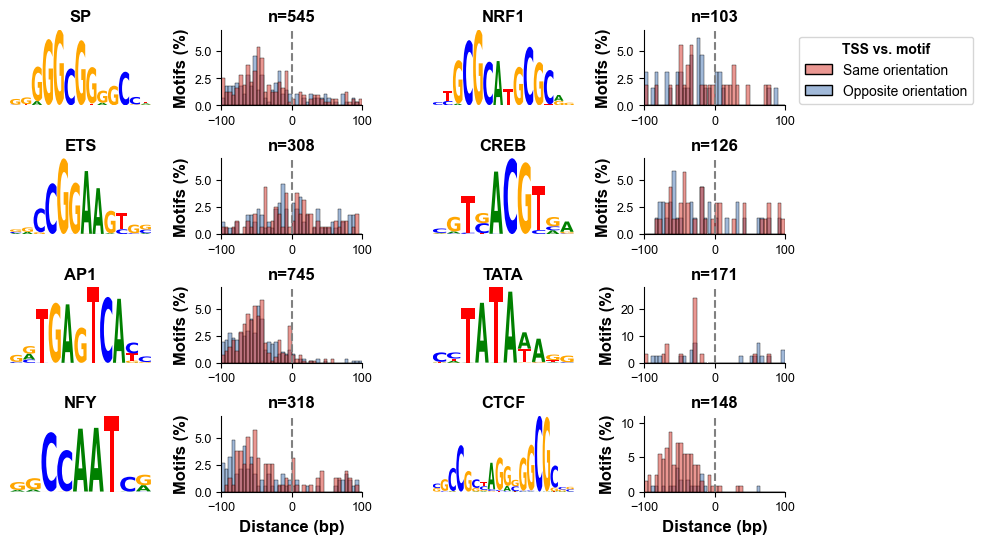

In [24]:
outputfile = f"{PROJECT_DIR_o}supp_figures/suppFig12b.pdf"
get_all_seqlets_distribution(motif_names2, patterns_IDs2, df_info, outputfile)